# Setup

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\n################################################################################\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Nov 23 14:40:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## System Setup

In [2]:
# Transformers installation
!pip install transformers datasets

# The Evaluate library provides a simple accuracy function
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Other

In [3]:
import numpy as np
import evaluate
import torch
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_linear_schedule_with_warmup

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pd.options.display.max_colwidth = 1000
pd.set_option('display.expand_frame_repr', False)

In [4]:
TOKEN_MAX_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 5e-5
SEED_VALUE = 42
TEST_DATASET_SIZE = 100
EVALUATE_AFTER_EPOCH = True

In [5]:
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)

# Dataset Preparation

In [6]:
# IMDB dataset from https://huggingface.co/datasets/imdb
dataset = load_dataset("imdb")

dataset["train"][100]

  0%|          | 0/3 [00:00<?, ?it/s]

{'text': "Terrible movie. Nuff Said.<br /><br />These Lines are Just Filler. The movie was bad. Why I have to expand on that I don't know. This is already a waste of my time. I just wanted to warn others. Avoid this movie. The acting sucks and the writing is just moronic. Bad in every way. The only nice thing about the movie are Deniz Akkaya's breasts. Even that was ruined though by a terrible and unneeded rape scene. The movie is a poorly contrived and totally unbelievable piece of garbage.<br /><br />OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum. First I waste my time watching this offal. Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is. Totally unnecessary.",
 'label': 0}

In [7]:
# Separate dataset
train_raw = dataset["train"].shuffle(seed=SEED_VALUE)
train_d_raw = train_raw.select(range(12500))
train_daux_raw = train_raw.select(range(12500, 25000))

test_raw = dataset["test"].shuffle(seed=SEED_VALUE)

In [8]:
# # Subsets - uncomment which set to use

# # Full D dataset
# train_dataset = train_d_raw
# eval_dataset = test_raw

# # Full D_aux dataset
# train_dataset = train_daux_raw
# eval_dataset = test_raw

# Smaller datasets for testing
train_dataset = train_d_raw.select(range(TEST_DATASET_SIZE))
eval_dataset = test_raw.select(range(TEST_DATASET_SIZE))

print("Train dataset positive: {}/{}".format(np.sum(train_dataset['label']), train_dataset.num_rows))
print("Eval dataset positive: {}/{}".format(np.sum(eval_dataset['label']), eval_dataset.num_rows))

Train dataset positive: 47/100
Eval dataset positive: 47/100


In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=TOKEN_MAX_LENGTH)

In [10]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_train_dataset.set_format("torch")

tokenized_eval_dataset = tokenized_eval_dataset.remove_columns(["text"])
tokenized_eval_dataset = tokenized_eval_dataset.rename_column("label", "labels")
tokenized_eval_dataset.set_format("torch")

In [12]:
# TODO: Consider whether masking is needed....

In [13]:
train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=BATCH_SIZE)

<a id='trainer'></a>

# BERT Training

## Prepare training settings

In [14]:
# Using "output_hidden_states = True" caused a CUDA out of memory error. Maybe can't use it while training, only during evaluation.

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, output_hidden_states = True)
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

In [16]:
num_training_steps = EPOCHS * len(train_dataloader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

## Visualizations

In [18]:
# dim_reducer = TSNE(n_components=2)
dim_reducer = PCA(n_components=2)

def visualize_layerwise_embeddings(hidden_states, masks, ys, epoch, title, layers_to_visualize=[0,1,2,3,8,9,10,11]):
    print('visualize_layerwise_embeddings for', title, 'epoch', epoch)
    global dim_reducer
    !mkdir -p tmp/plots/{title}
    num_layers = len(layers_to_visualize)
    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6
    ax = [fig.add_subplot(num_layers/4,4,i+1) for i in range(num_layers)]
    ys = ys.numpy().reshape(-1)
    for i,layer_i in enumerate(layers_to_visualize):#range(hidden_states):
        layer_hidden_states = hidden_states[layer_i]
        averaged_layer_hidden_states = torch.div(layer_hidden_states.sum(dim=1), masks.sum(dim=1,keepdim=True))
        layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())
        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':ys})
        df.label = df.label.astype(int)
        sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i])
        fig.suptitle(f"{title}: epoch {epoch}")
        ax[i].set_title(f"layer {layer_i+1}")
    plt.savefig(f'tmp/plots/{title}/{epoch}.png',format='png',pad_inches=0)
    print()

## Train Model

In [19]:
metric = evaluate.load("accuracy")
def evaluate_model(e_model, e_dataloader):
  e_progress_bar = tqdm(range(len(e_dataloader)))
  e_model.eval()
  e_total_loss = 0
  e_count = 0
  for batch in e_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = e_model(**batch)

      e_logits = outputs.logits
      e_count += batch['labels'].shape[0]
      e_total_loss += outputs.loss.detach() * batch['labels'].shape[0]
      predictions = torch.argmax(e_logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
      e_progress_bar.update(1)

  e_acc = metric.compute()['accuracy']
  e_loss = e_total_loss / e_count
  return e_acc, e_loss

In [20]:
def visualize_model(v_model, v_dataloader, text=""):
  v_progress_bar = tqdm(range(len(v_dataloader)))
  v_model.eval()
  v_model.config.output_attentions = True

  v_total_loss = 0
  v_count = 0
  v_masks = torch.zeros(0, TOKEN_MAX_LENGTH)
  v_ys = torch.zeros(0,1)
  v_hidden_states = None
  for batch in v_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = v_model(**batch)

      v_logits = outputs.logits
      v_count += batch['labels'].shape[0]
      v_total_loss += outputs.loss.detach() * batch['labels'].shape[0]

      hidden_states = outputs.hidden_states[1:]
      v_masks = torch.cat([v_masks, batch["attention_mask"].cpu()])
      v_ys = torch.cat([v_ys, batch['labels'].cpu().view(-1,1)])

      if type(v_hidden_states) == type(None):
          v_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
      else:
          v_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()]) for layer_hidden_state_all,layer_hidden_state_batch in zip(v_hidden_states,hidden_states))

      predictions = torch.argmax(v_logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
      v_progress_bar.update(1)

  visualize_layerwise_embeddings(v_hidden_states, v_masks, v_ys, epoch, text)
  v_loss = v_total_loss / v_count
  v_acc = metric.compute()['accuracy']
  return v_acc, v_loss

Epoch 0


  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for train_data epoch 0



  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for eval_data epoch 0

  Accuracy: 0.47
  Loss: 0.7351160049438477
Epoch 1


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for train_data epoch 1



  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for eval_data epoch 1

  Accuracy: 0.55
  Loss: 0.7015252709388733
Epoch 2


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for train_data epoch 2



  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for eval_data epoch 2

  Accuracy: 0.53
  Loss: 0.6881818175315857
Epoch 3


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for train_data epoch 3



  0%|          | 0/13 [00:00<?, ?it/s]

visualize_layerwise_embeddings for eval_data epoch 3

  Accuracy: 0.55
  Loss: 0.6969771385192871


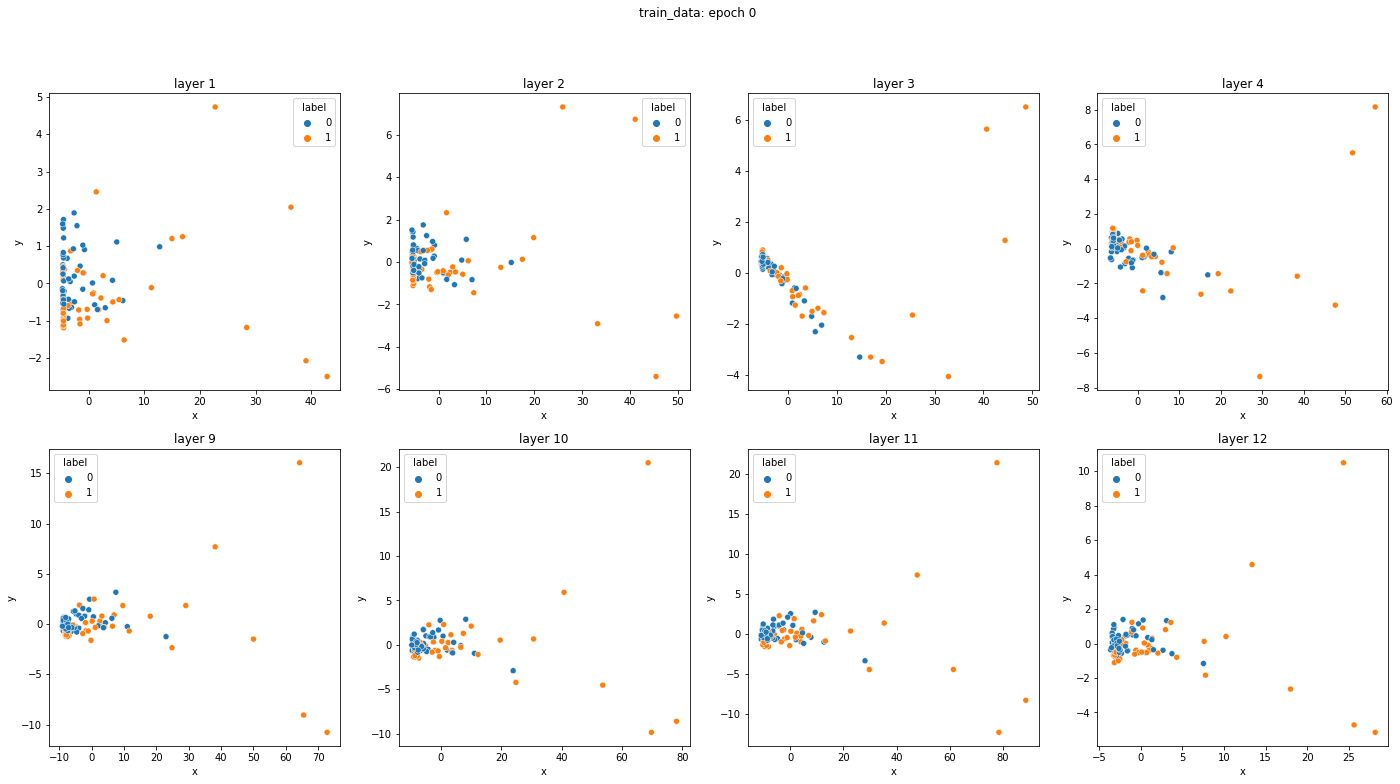

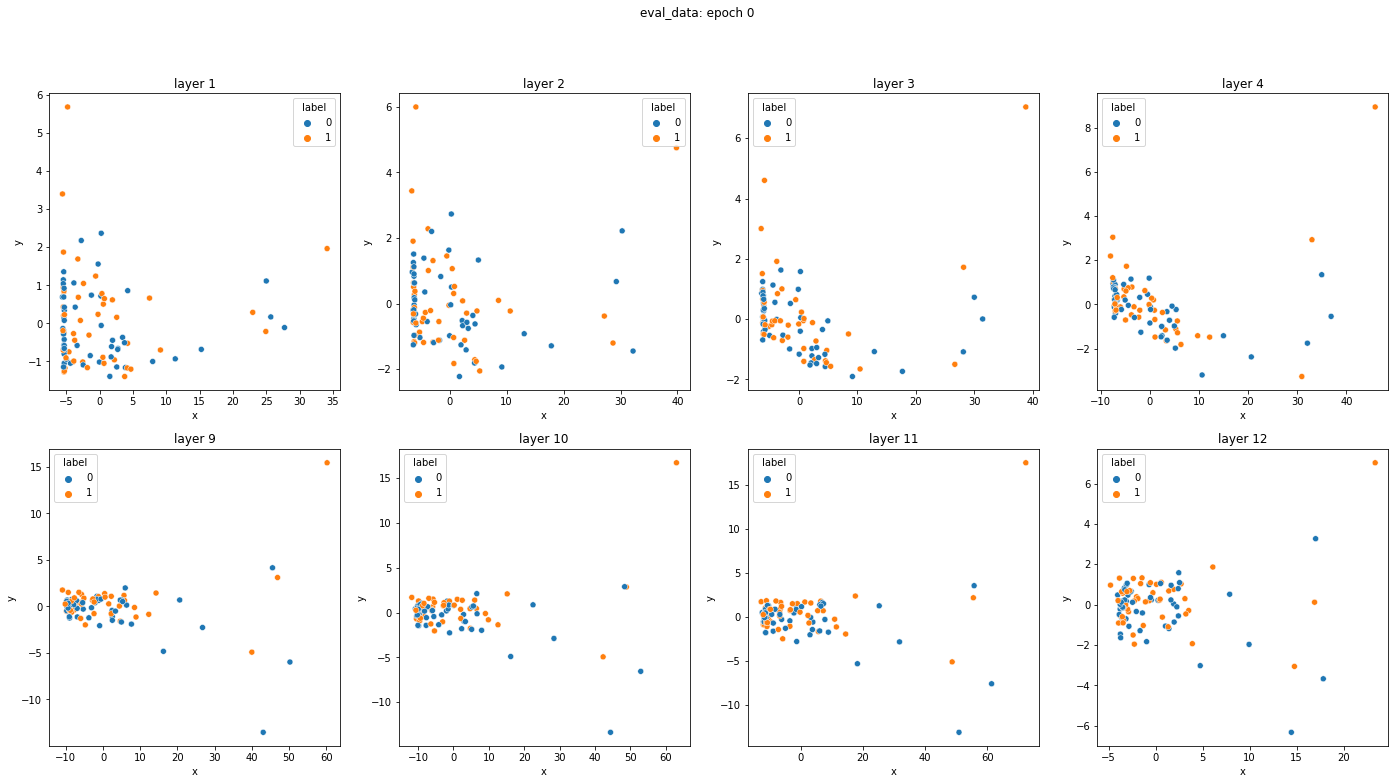

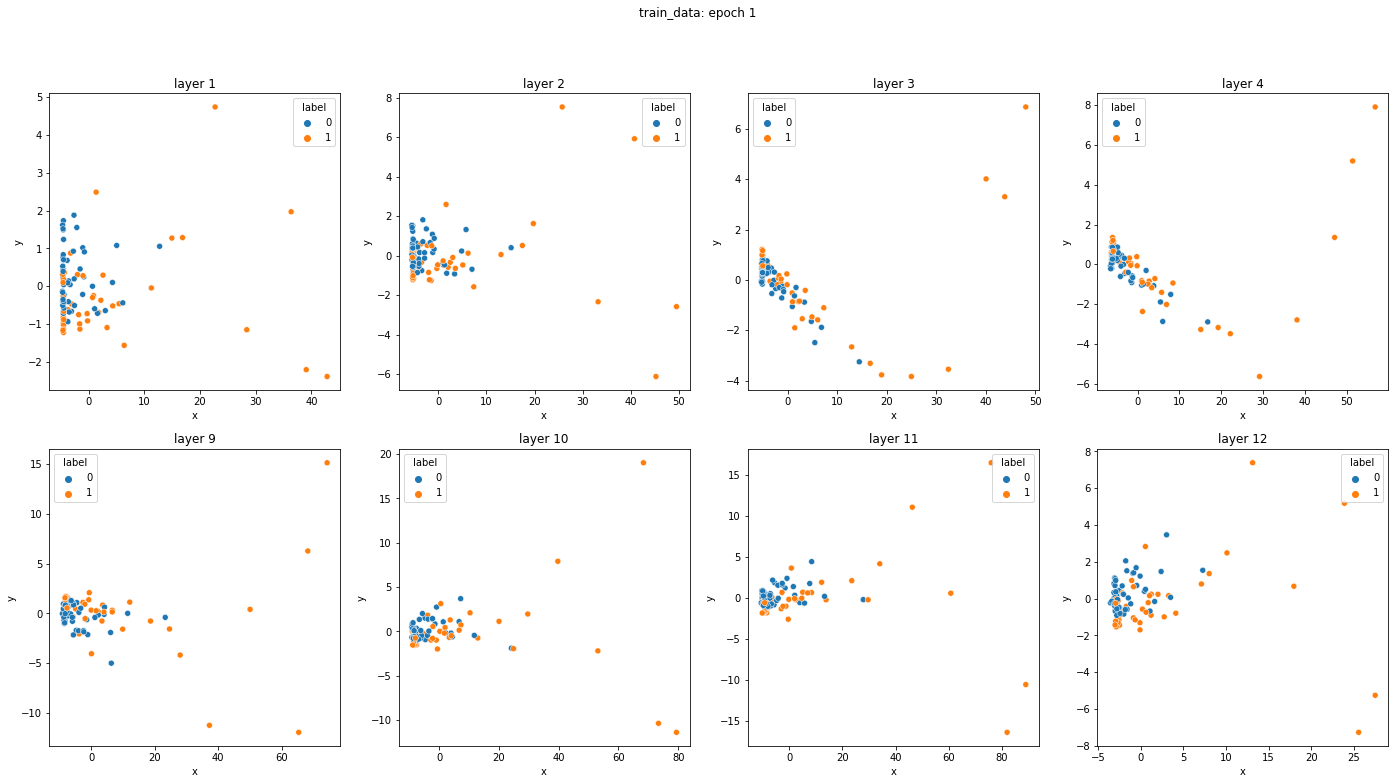

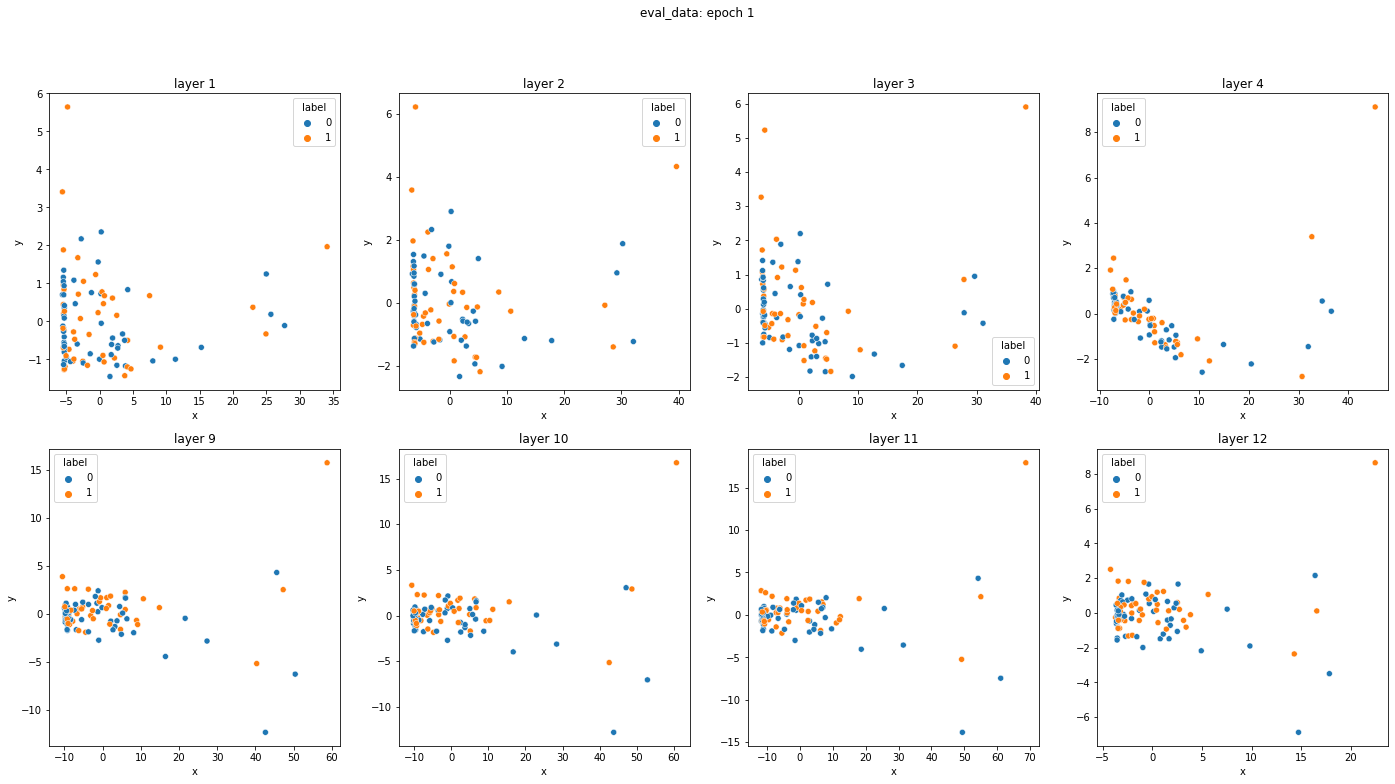

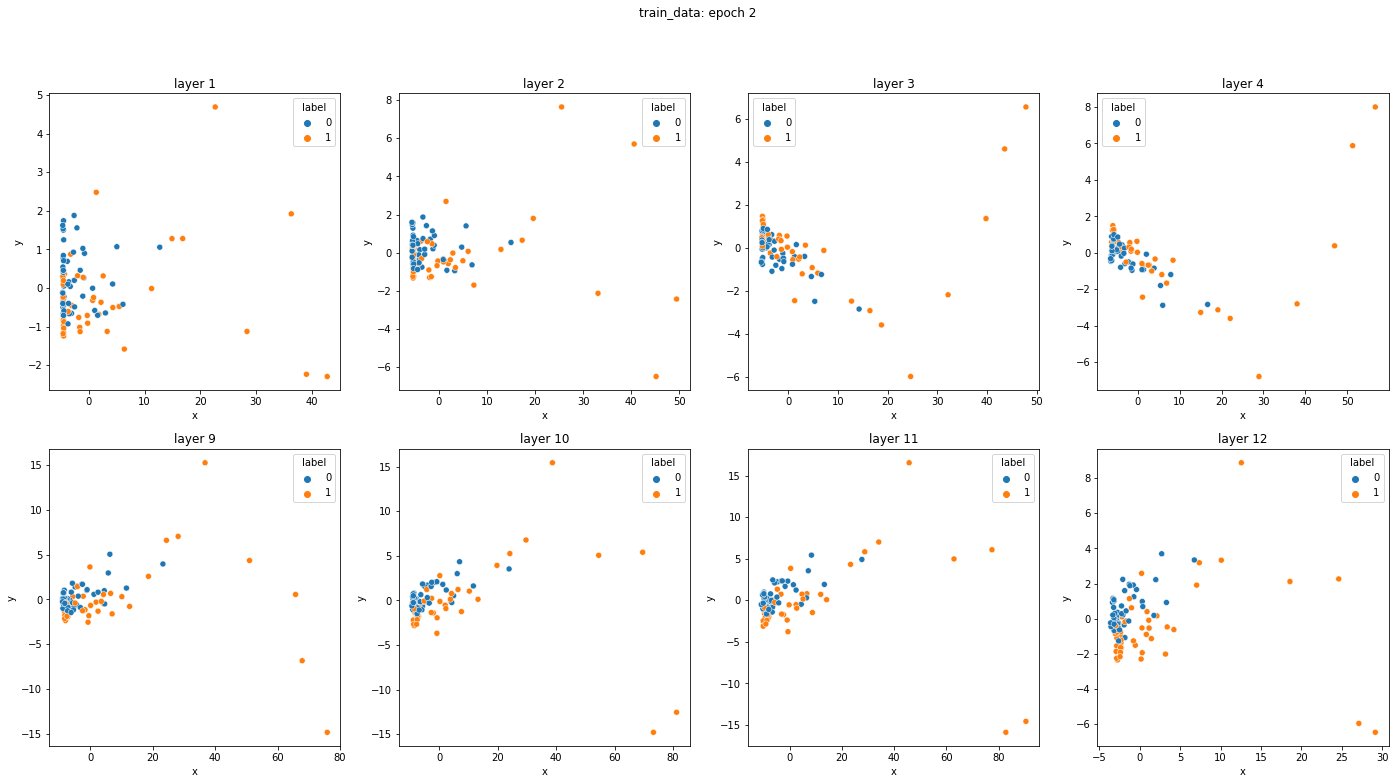

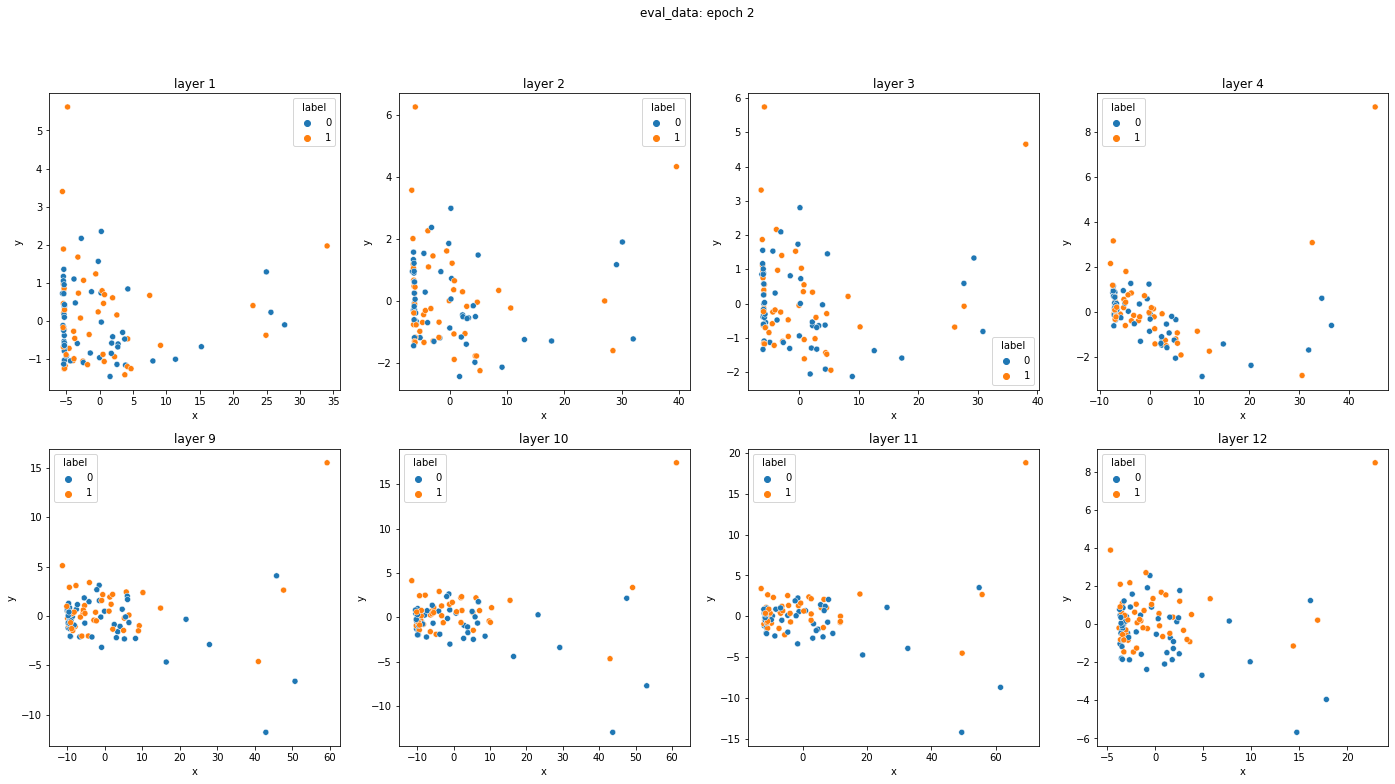

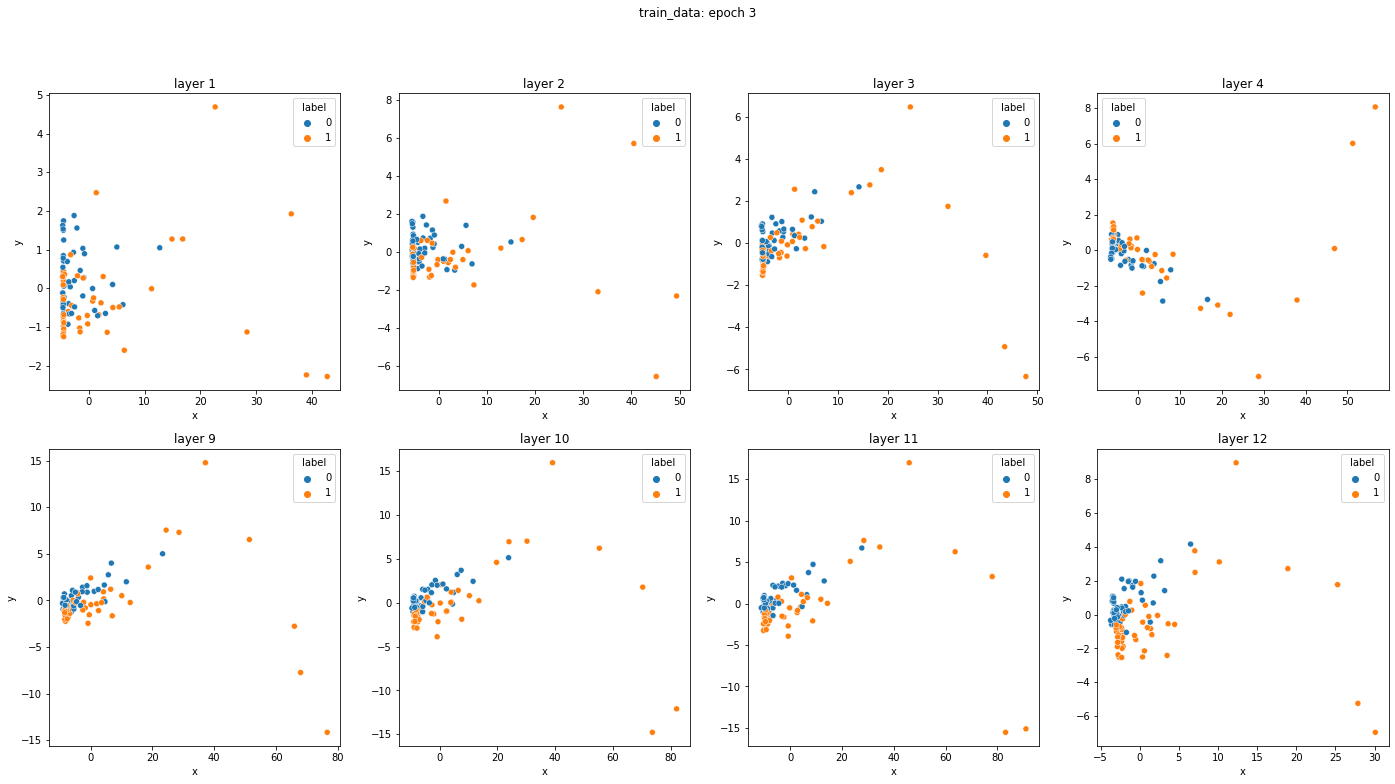

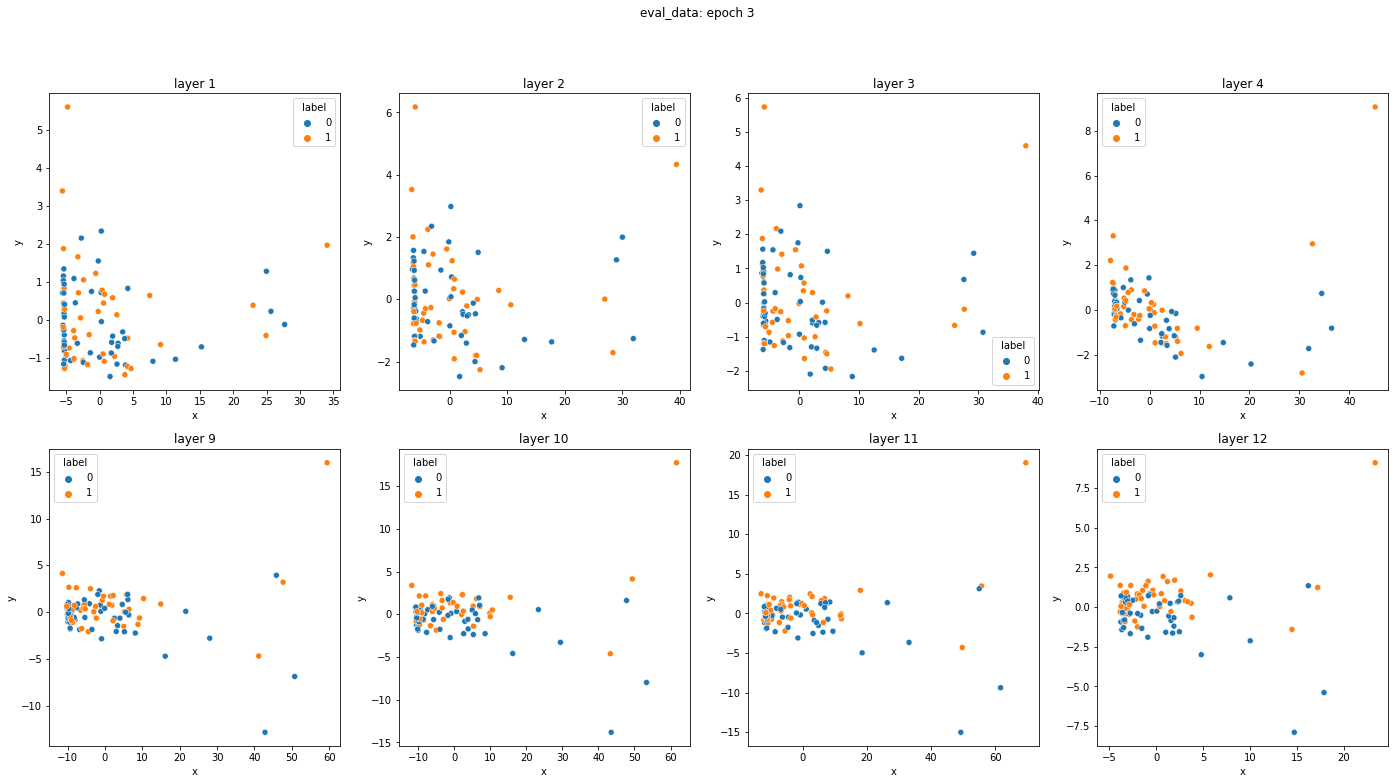

In [21]:
for epoch in range(EPOCHS+1):
    print("Epoch {}".format(epoch))
    if epoch != 0:
      progress_bar = tqdm(range(len(train_dataloader)))
      model.train()
      for batch in train_dataloader:
          batch = {k: v.to(device) for k, v in batch.items()}
          outputs = model(**batch)
          loss = outputs.loss
          loss.backward()

          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()
          progress_bar.update(1)
      
    _, _ = visualize_model(model, train_dataloader, "train_data")
    if EVALUATE_AFTER_EPOCH:
      acc, loss = visualize_model(model, eval_dataloader, "eval_data")
      print("  Accuracy: {}".format(acc))
      print("  Loss: {}".format(loss))

In [22]:
print(evaluate_model(model, eval_dataloader))

  0%|          | 0/13 [00:00<?, ?it/s]

(0.55, tensor(0.6970, device='cuda:0'))


## Save model weights

In [23]:
model.save_pretrained("bert_imdb_viz")

<a id='keras'></a>